# Import Libraries needed to run notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# I. Read in Data

In [2]:
# Define optimal nm for 12 point spectrum
nm_optimal = [680, 707, 735, 746, 757, 768, 779, 800, 825, 850, 875, 900]
nm_optimal

[680, 707, 735, 746, 757, 768, 779, 800, 825, 850, 875, 900]

## Hb

In [3]:
# Read in Hb dat, filtering on nms of choice
Hb_dat = pd.read_csv(r'Hb.csv')
Hb_dat = Hb_dat.loc[Hb_dat['nm'].isin(nm_optimal)].copy()
Hb_dat['signal'] = [int(x.split(';')[1]) for x in Hb_dat['var1']]

# Save max signal for normalization purposes
max_signal = np.max(Hb_dat['signal'])
Hb_dat['signal'] = Hb_dat['signal']/max_signal
Hb_dat

,nm,var1,var2,signal
20,680,0000;2547,1957,1.000000
47,707,0000;1654,307,0.649391
75,735,0000;1060,3212,0.416176
86,746,0000;1337,439,0.524931
97,757,0000;1563,7731,0.613663
108,768,0000;1407,3565,0.552415
119,779,0000;1125,8628,0.441696
140,800,0000;778,2100,0.305457
165,825,0000;685,3891,0.268944
190,850,0000;683,2000,0.268159


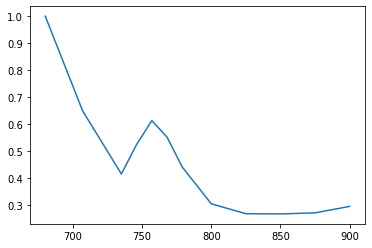

In [4]:
plt.plot(Hb_dat['nm'], Hb_dat['signal'])

In [5]:
# Read in HbO2 dat
HbO2_dat = pd.read_csv(r'HbO2.csv')
HbO2_dat = HbO2_dat.loc[HbO2_dat['nm'].isin(nm_optimal)].copy()
HbO2_dat['signal'] = [int(x.split(';')[1]) for x in HbO2_dat['var1']]
HbO2_dat['signal'] = HbO2_dat['signal']/max_signal
HbO2_dat

,nm,var1,var2,signal
20,680,0000;268,6262,0.105222
47,707,0000;297,8163,0.116608
75,735,0000;415,7008,0.162937
86,746,0000;499,1432,0.195917
97,757,0000;572,6159,0.224578
108,768,0000;642,5321,0.252061
119,779,0000;698,2955,0.274048
140,800,0000;796,9595,0.312525
165,825,0000;942,806,0.369847
190,850,0000;1055,1370,0.414213


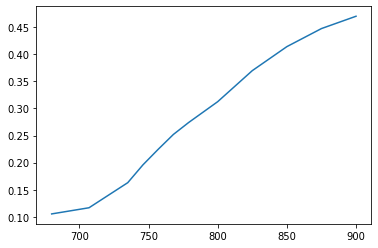

In [6]:
plt.plot(HbO2_dat['nm'], HbO2_dat['signal'])

### x values in spectrum (frequencies)

In [7]:
# Define x values
x = Hb_dat['nm'].values
x

array([680, 707, 735, 746, 757, 768, 779, 800, 825, 850, 875, 900])

### number of fractional components

In [8]:
# Number of fractional components - rows in simulated dataset
fractional_components = np.linspace(0, 1, 1001)
fractional_components

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

### Function to create simulated dataset

In [9]:
# Function to create simulated dataset
def create_simulated_dataset(fractions, func_1, func_2, noise_sd):
    
    # Initialize list to hold dataset
    dat = []
    
    # Loop through to create dataset
    for fraction in fractions:
    
        # Define fractional components for each function
        function_1_fraction = fraction
        function_2_fraction = np.round(1 - fraction,2)
    
        # Multiply signal values by fraction
        func_1_fraction = func_1*function_1_fraction
        func_2_fraction = func_2*function_2_fraction
    
        # Add fractional signals together
        y_sum_fraction = func_1_fraction + func_2_fraction
        
        # Add random white gaussian noise to summed-spectrum
        noise = np.random.normal(0,noise_sd,len(y_sum_fraction))
        y_sum_fraction = y_sum_fraction + noise
    
        # Append result
        dat.append([function_1_fraction,
                    function_2_fraction] + list(y_sum_fraction))

    # Convert to dataframe
    dat = pd.DataFrame(dat,
                       columns = ['y1', 'y2',
                                  'x1', 'x2', 'x3', 'x4', 'x5', 'x6',
                                  'x7', 'x8', 'x9', 'x10', 'x11', 'x12'])
    
    # Return dataset
    return(dat)

# II. spectral unmixing

In [10]:
# Create example dataset - no noise
simulated_dataset = create_simulated_dataset(fractional_components, 
                                             Hb_dat['signal'].values, 
                                             HbO2_dat['signal'].values, 
                                             0)
simulated_dataset

,y1,y2,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.00,1.00,0.105222,0.116608,0.162937,0.195917,0.224578,0.252061,0.274048,0.312525,0.369847,0.414213,0.447585,0.470357
1,0.01,0.99,0.114170,0.121936,0.165469,0.199207,0.228469,0.255065,0.275724,0.312454,0.368838,0.412752,0.445830,0.468614
2,0.02,0.98,0.123117,0.127263,0.168002,0.202497,0.232360,0.258068,0.277401,0.312383,0.367829,0.411292,0.444075,0.466871
3,0.03,0.97,0.132065,0.132591,0.170534,0.205787,0.236250,0.261072,0.279077,0.312313,0.366820,0.409831,0.442320,0.465128
4,0.04,0.96,0.141013,0.137919,0.173066,0.209077,0.240141,0.264075,0.280754,0.312242,0.365811,0.408371,0.440565,0.463384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.04,0.964209,0.628080,0.406046,0.511771,0.598100,0.540400,0.434990,0.305740,0.272980,0.274001,0.279105,0.303007
97,0.97,0.03,0.973157,0.633408,0.408579,0.515061,0.601991,0.543404,0.436667,0.305669,0.271971,0.272540,0.277350,0.301264
98,0.98,0.02,0.982104,0.638736,0.411111,0.518351,0.605881,0.546408,0.438343,0.305599,0.270962,0.271080,0.275595,0.299521
99,0.99,0.01,0.991052,0.644064,0.413644,0.521641,0.609772,0.549411,0.440020,0.305528,0.269953,0.269619,0.273840,0.297778


## a) basic concept on single spectrum

### create X --> 100% Hb and 100% HbO<sub>2</sub> msot spectra

In [11]:
# Define X
y1_100 = np.squeeze(simulated_dataset.iloc[len(simulated_dataset)-1,
                                           2:].to_numpy())
y2_100 = np.squeeze(simulated_dataset.iloc[0,
                                           2:].to_numpy())

X = np.array([y1_100, y2_100]).T
X

array([[1.        , 0.10522183],
       [0.64939144, 0.11660777],
       [0.41617589, 0.16293679],
       [0.52493129, 0.19591676],
       [0.61366313, 0.22457793],
       [0.55241461, 0.25206125],
       [0.44169611, 0.2740479 ],
       [0.3054574 , 0.31252454],
       [0.26894386, 0.36984688],
       [0.26815862, 0.4142128 ],
       [0.27208481, 0.44758539],
       [0.29603455, 0.47035728]])

### create y --> msot spectra at user defined fractional components

In [12]:
# User defined y signal at given y1, y2 fractional components
y1_frac = 0.1 # User defined
dat_temp = simulated_dataset.loc[simulated_dataset['y1']==y1_frac].copy()
y = np.squeeze(dat_temp.iloc[:,2:].to_numpy())
y

array([0.19469965, 0.16988614, 0.1882607 , 0.22881822, 0.26348645,
       0.28209658, 0.29081272, 0.31181782, 0.35975658, 0.39960738,
       0.43003534, 0.45292501])

### estimate fractional components of y using spectral unmixing

In [13]:
# Use spectral unmixing to get fractional components
linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(X, y)

# Estimated fractional components (y1_frac, y2_frac)
y1_estimate, y2_estimate = linear_regressor.coef_

print('y1 estimate: ' + str(np.round(y1_estimate,2)))
print('y2 estimate: ' + str(np.round(y2_estimate,2)))

y1 estimate: 0.1
y2 estimate: 0.9


### estimated components of y1 and y2 in msot spectrum

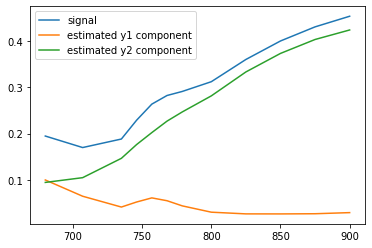

In [14]:
# Plot
plt.plot(x, y, label = "signal") # Raw Signal

# y signals for each components based on regression estimates
## y1
y1_frac = y1_estimate
y1_signal = Hb_dat['signal'].values*y1_frac
plt.plot(x, y1_signal, label = "estimated y1 component")
## y2
y2_frac = y2_estimate
y2_signal = HbO2_dat['signal'].values*y2_frac
plt.plot(x, y2_signal, label = "estimated y2 component")

# Plot
plt.legend()
plt.show()

## b) calculate rmse of estimates on all spectra in dataset

In [15]:
# Define actual y1s and y2s
y1s = list(simulated_dataset['y1'].values)
y2s = list(simulated_dataset['y2'].values)

# Preallocate lists to hold y1 and y2 estimates
y1_estimates = []
y2_estimates = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Loop through each spectrum and estimate y1 and y2 using spectral unmixing
for spectrum_iterator in range(len(simulated_dataset)):
    y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                          2:].to_numpy())
    # Use spectral unmixing to get fractional components
    linear_regressor.fit(X, y)

    # Estimated fractional components (y1_frac, y2_frac)
    y1_estimate, y2_estimate = linear_regressor.coef_
    
    # Append results
    y1_estimates.append(y1_estimate)
    y2_estimates.append(y2_estimate)
    
# Calculate rmse for y1 and y2
rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                             squared=False)
print('rmse_y1: ' + str(rmse_y1))
rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                             squared=False)
print('rmse_y2: ' + str(rmse_y2))

rmse_y1: 2.1999718752077506e-16
rmse_y2: 1.3373187378669245e-16


In [16]:
# Calculate average rmse
avg_rmse = (rmse_y1 + rmse_y2)/2
print('average rmse: ' + str(avg_rmse))

average rmse: 1.7686453065373377e-16


## c) full simulated experiment

In [17]:
# Initialize result array
results = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Define noise levels
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     Hb_dat['signal'].values, 
                                                     HbO2_dat['signal'].values, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)

        # Preallocate lists to hold y1 and y2 estimates
        y1_estimates = []
        y2_estimates = []

        # Loop through each spectrum and estimate y1 and y2 using spectral unmixing
        for spectrum_iterator in range(len(simulated_dataset)):
            y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                                  2:].to_numpy())
            # Use spectral unmixing to get fractional components
            linear_regressor.fit(X, y)

            # Estimated fractional components (y1_frac, y2_frac)
            y1_estimate, y2_estimate = linear_regressor.coef_
    
            # Append results
            y1_estimates.append(y1_estimate)
            y2_estimates.append(y2_estimate)
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append results
        results.append([noise_level, rep, avg_rmse])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse'])
results

,noise_level,rep,avg_rmse
0,0.0,1.0,1.768645e-16
1,0.0,2.0,1.768645e-16
2,0.0,3.0,1.768645e-16
3,0.0,4.0,1.768645e-16
4,0.0,5.0,1.768645e-16
...,...,...,...
495,0.2,96.0,2.082548e-01
496,0.2,97.0,2.088114e-01
497,0.2,98.0,2.037918e-01
498,0.2,99.0,1.909377e-01


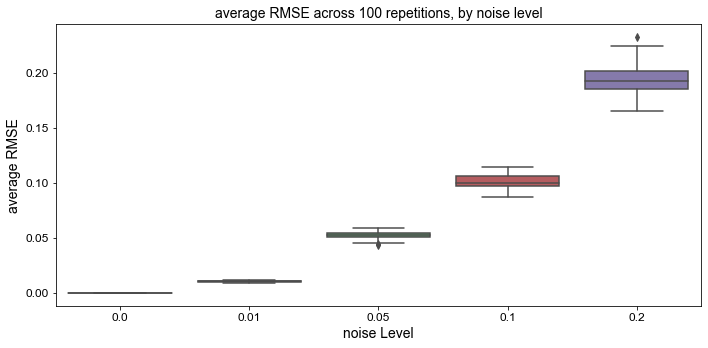

In [18]:
# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

# III. machine learning

In [10]:
# Create X - no noise for training
simulated_dataset = create_simulated_dataset(fractional_components, 
                                             Hb_dat['signal'].values, 
                                             HbO2_dat['signal'].values, 
                                             0)
X = simulated_dataset.iloc[:, 2:].values
X

array([[0.10522183, 0.11660777, 0.16293679, ..., 0.4142128 , 0.44758539,
        0.47035728],
       [0.10622183, 0.11725717, 0.16335296, ..., 0.41448096, 0.44785748,
        0.47065332],
       [0.10722183, 0.11790656, 0.16376914, ..., 0.41474912, 0.44812956,
        0.47094935],
       ...,
       [0.998     , 0.64809266, 0.41534354, ..., 0.2676223 , 0.27154064,
        0.29544248],
       [0.999     , 0.64874205, 0.41575972, ..., 0.26789046, 0.27181272,
        0.29573852],
       [1.        , 0.64939144, 0.41617589, ..., 0.26815862, 0.27208481,
        0.29603455]])

In [11]:
# Create y
y = simulated_dataset.iloc[:, 0:2].values
y

array([[0.   , 1.   ],
       [0.001, 1.   ],
       [0.002, 1.   ],
       ...,
       [0.998, 0.   ],
       [0.999, 0.   ],
       [1.   , 0.   ]])

## a) Ridge Regression

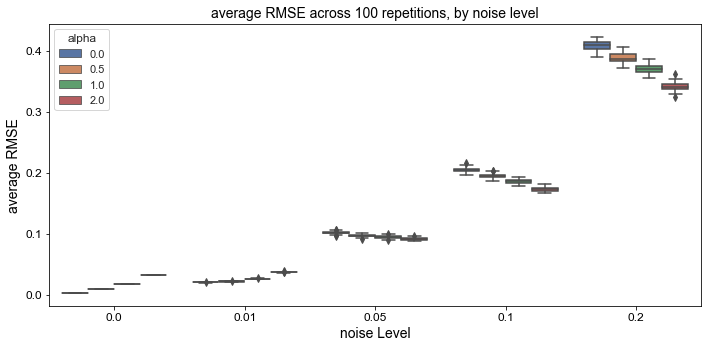

In [12]:
# Initialize result array
results = []

# Define alphas
alphas = [0, 0.5, 1, 2]
for alpha in alphas:
    model = Ridge(positive=True, alpha=alpha)
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, alpha])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse', 'alpha'])

# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='alpha',
            data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

## b) KNN

In [13]:
# Initialize result array
results = []

# Define alphas
neighbors = np.linspace(1, 31, 16)
neighbors = [int(x) for x in neighbors]
for neighbor in neighbors:
    model = KNeighborsRegressor(n_neighbors=neighbor)
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, neighbor])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse', 'neighbors'])

results

,noise_level,rep,avg_rmse,neighbors
0,0.0,1.0,0.000000,1
1,0.0,2.0,0.000000,1
2,0.0,3.0,0.000000,1
3,0.0,4.0,0.000000,1
4,0.0,5.0,0.000000,1
...,...,...,...,...
7995,0.2,96.0,0.141212,31
7996,0.2,97.0,0.145959,31
7997,0.2,98.0,0.136404,31
7998,0.2,99.0,0.143517,31


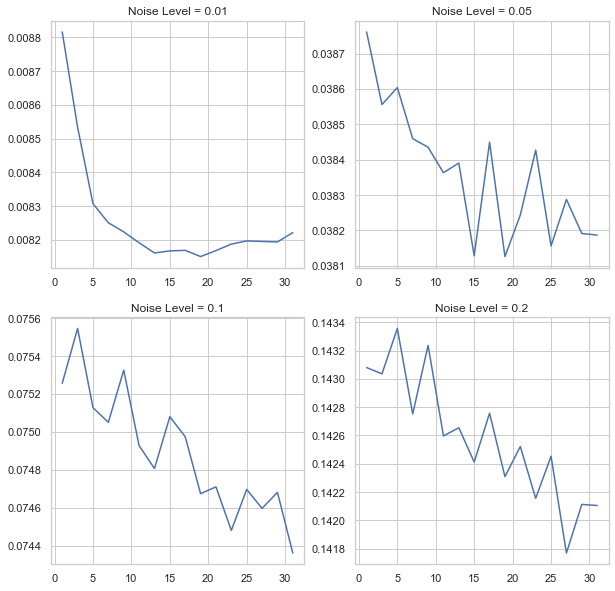

In [14]:
# Average rmse for each noise level, by K value

## Condense to 1 value per unique noise_level-neighbors value
avg_results = []
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
neighbors = np.linspace(1, 31, 16)
neighbors = [int(x) for x in neighbors]
for noise_level in noise_levels:
    for neighbor in neighbors:
        dat_temp = results.loc[(results['noise_level']==noise_level)&\
                               (results['neighbors']==neighbor)].copy()
        dat_temp.reset_index(inplace=True, drop=True)
        mean_val = np.mean(dat_temp['avg_rmse'].values)
        avg_results.append([noise_level, neighbor, mean_val])
avg_results = pd.DataFrame(avg_results,
                           columns=['noise_level', 'neighbors', 'mean_val'])

# Plot
fig, axs = plt.subplots(2, 2, figsize = (10,10))
# Noise Level 0.01
dat_temp = avg_results.loc[avg_results['noise_level']==0.01].copy()
axs[0, 0].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[0, 0].title.set_text('Noise Level = 0.01')
# Noise Level 0.05
dat_temp = avg_results.loc[avg_results['noise_level']==0.05].copy()
axs[0, 1].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[0, 1].title.set_text('Noise Level = 0.05')
# Noise Level 0.1
dat_temp = avg_results.loc[avg_results['noise_level']==0.1].copy()
axs[1, 0].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[1, 0].title.set_text('Noise Level = 0.1')
# Noise Level 0.2
dat_temp = avg_results.loc[avg_results['noise_level']==0.2].copy()
axs[1, 1].plot(dat_temp['neighbors'], dat_temp['mean_val'])
axs[1, 1].title.set_text('Noise Level = 0.2')

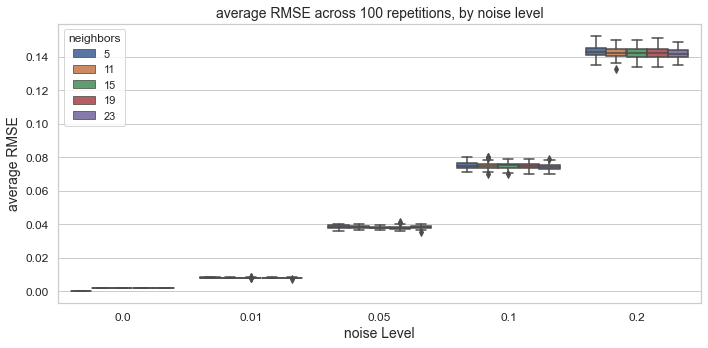

In [15]:
# Box Plots of select k values
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='neighbors',
            data = results.loc[results['neighbors'].isin([5,11,15,19,23])])
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

## c) Random Forest Regressor

In [20]:
# Initialize result array
results = []

# Define alphas
model_parameters = [[100, 4, 20],
                    [100, 5, 20],
                    [100, 6, 20],
                    [100, 4, 30],
                    [100, 5, 30],
                    [100, 6, 30],
                    [100, 4, 40],
                    [100, 5, 40],
                    [100, 6, 40],
                    [100, 4, 40],
                    [100, 5, 40],
                    [100, 6, 40]]

model_num = 1
for model_params in model_parameters:
    model = RandomForestRegressor(n_estimators=model_params[0],
                                  max_features=model_params[1],
                                  max_depth=model_params[2])
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         Hb_dat['signal'].values, 
                                                         HbO2_dat['signal'].values, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, model_num])
    
    model_num+=1

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 
                                  'rep', 
                                  'avg_rmse', 
                                  'model_num'])
results

,noise_level,rep,avg_rmse,model_num
0,0.0,1.0,0.000802,1
1,0.0,2.0,0.000802,1
2,0.0,3.0,0.000802,1
3,0.0,4.0,0.000802,1
4,0.0,5.0,0.000802,1
...,...,...,...,...
5995,0.2,96.0,0.153977,12
5996,0.2,97.0,0.157595,12
5997,0.2,98.0,0.155197,12
5998,0.2,99.0,0.155940,12


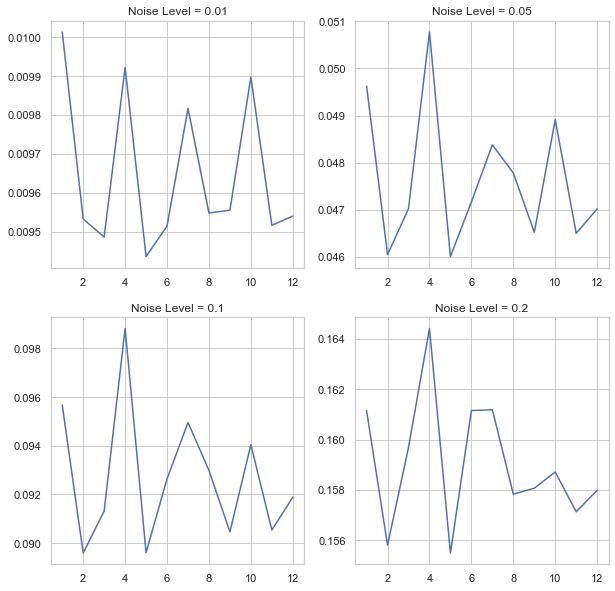

In [21]:
# Average rmse for each noise level, by model value

## Condense to 1 value per unique noise_level-model value
avg_results = []
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
models = [1,2,3,4,5,6,7,8,9,10,11,12]
for noise_level in noise_levels:
    for model_num in models:
        dat_temp = results.loc[(results['noise_level']==noise_level)&\
                               (results['model_num']==model_num)].copy()
        dat_temp.reset_index(inplace=True, drop=True)
        mean_val = np.mean(dat_temp['avg_rmse'].values)
        avg_results.append([noise_level, model_num, mean_val])
avg_results = pd.DataFrame(avg_results,
                           columns=['noise_level', 'model_num', 'mean_val'])

# Plot
fig, axs = plt.subplots(2, 2, figsize = (10,10))
# Noise Level 0.01
dat_temp = avg_results.loc[avg_results['noise_level']==0.01].copy()
axs[0, 0].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[0, 0].title.set_text('Noise Level = 0.01')
# Noise Level 0.05
dat_temp = avg_results.loc[avg_results['noise_level']==0.05].copy()
axs[0, 1].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[0, 1].title.set_text('Noise Level = 0.05')
# Noise Level 0.1
dat_temp = avg_results.loc[avg_results['noise_level']==0.1].copy()
axs[1, 0].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[1, 0].title.set_text('Noise Level = 0.1')
# Noise Level 0.2
dat_temp = avg_results.loc[avg_results['noise_level']==0.2].copy()
axs[1, 1].plot(dat_temp['model_num'], dat_temp['mean_val'])
axs[1, 1].title.set_text('Noise Level = 0.2')

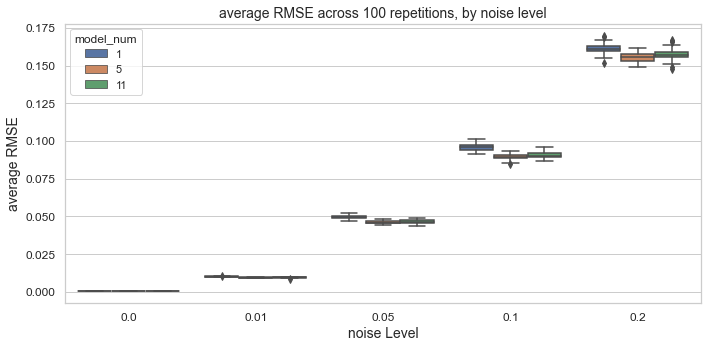

In [22]:
# Box Plots of select k values
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='model_num',
            data = results.loc[results['model_num'].isin([1,5,11])])
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

# IV. results of best models on plot

In [23]:
# Training dataset
train_dataset = create_simulated_dataset(fractional_components, 
                                         Hb_dat['signal'].values, 
                                         HbO2_dat['signal'].values, 
                                         0)
train_dataset

,y1,y2,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.000,1.0,0.105222,0.116608,0.162937,0.195917,0.224578,0.252061,0.274048,0.312525,0.369847,0.414213,0.447585,0.470357
1,0.001,1.0,0.106222,0.117257,0.163353,0.196442,0.225192,0.252614,0.274490,0.312830,0.370116,0.414481,0.447857,0.470653
2,0.002,1.0,0.107222,0.117907,0.163769,0.196967,0.225805,0.253166,0.274931,0.313135,0.370385,0.414749,0.448130,0.470949
3,0.003,1.0,0.108222,0.118556,0.164185,0.197492,0.226419,0.253718,0.275373,0.313441,0.370654,0.415017,0.448402,0.471245
4,0.004,1.0,0.109222,0.119205,0.164601,0.198016,0.227033,0.254271,0.275815,0.313746,0.370923,0.415285,0.448674,0.471541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.996,0.0,0.996000,0.646794,0.414511,0.522832,0.611208,0.550205,0.439929,0.304236,0.267868,0.267086,0.270996,0.294850
997,0.997,0.0,0.997000,0.647443,0.414927,0.523356,0.611822,0.550757,0.440371,0.304541,0.268137,0.267354,0.271269,0.295146
998,0.998,0.0,0.998000,0.648093,0.415344,0.523881,0.612436,0.551310,0.440813,0.304846,0.268406,0.267622,0.271541,0.295442
999,0.999,0.0,0.999000,0.648742,0.415760,0.524406,0.613049,0.551862,0.441254,0.305152,0.268675,0.267890,0.271813,0.295739


In [24]:
# Define X for spectral-unmixing
y1_100 = np.squeeze(train_dataset.iloc[len(train_dataset)-1,
                                       2:].to_numpy())
y2_100 = np.squeeze(train_dataset.iloc[0,
                                       2:].to_numpy())

X_unmixing = np.array([y1_100, y2_100]).T
X_unmixing

array([[1.        , 0.10522183],
       [0.64939144, 0.11660777],
       [0.41617589, 0.16293679],
       [0.52493129, 0.19591676],
       [0.61366313, 0.22457793],
       [0.55241461, 0.25206125],
       [0.44169611, 0.2740479 ],
       [0.3054574 , 0.31252454],
       [0.26894386, 0.36984688],
       [0.26815862, 0.4142128 ],
       [0.27208481, 0.44758539],
       [0.29603455, 0.47035728]])

In [25]:
# Define X for machine learning
X_ml = train_dataset.iloc[:, 2:].values
X_ml

array([[0.10522183, 0.11660777, 0.16293679, ..., 0.4142128 , 0.44758539,
        0.47035728],
       [0.10622183, 0.11725717, 0.16335296, ..., 0.41448096, 0.44785748,
        0.47065332],
       [0.10722183, 0.11790656, 0.16376914, ..., 0.41474912, 0.44812956,
        0.47094935],
       ...,
       [0.998     , 0.64809266, 0.41534354, ..., 0.2676223 , 0.27154064,
        0.29544248],
       [0.999     , 0.64874205, 0.41575972, ..., 0.26789046, 0.27181272,
        0.29573852],
       [1.        , 0.64939144, 0.41617589, ..., 0.26815862, 0.27208481,
        0.29603455]])

In [26]:
# Define y for machine learning
y_ml = train_dataset.iloc[:, 0:2].values
y_ml

array([[0.   , 1.   ],
       [0.001, 1.   ],
       [0.002, 1.   ],
       ...,
       [0.998, 0.   ],
       [0.999, 0.   ],
       [1.   , 0.   ]])

In [27]:
# Train models
ridge_model = Ridge(positive=True, alpha=1).fit(X_ml, y_ml)
knn_model = KNeighborsRegressor(n_neighbors=19).fit(X_ml, y_ml)
RFR_model = RandomForestRegressor(n_estimators=100,
                                  max_features=5,
                                  max_depth=30).fit(X_ml, y_ml)

In [28]:
# Define model for spectral unmixing
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

In [29]:
# Initialize result array
results = []

# Define noise levels
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        ## 1) Create Simulated Dataset
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     Hb_dat['signal'].values, 
                                                     HbO2_dat['signal'].values, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)
        
        ## 2) Spectral unmixing

        # Preallocate lists to hold y1 and y2 estimates
        y1_estimates = []
        y2_estimates = []

        # Loop through each spectrum and estimate y1 and y2 using spectral unmixing
        for spectrum_iterator in range(len(simulated_dataset)):
            y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                                  2:].to_numpy())
            # Use spectral unmixing to get fractional components
            linear_regressor.fit(X_unmixing, y)

            # Estimated fractional components (y1_frac, y2_frac)
            y1_estimate, y2_estimate = linear_regressor.coef_
    
            # Append results
            y1_estimates.append(y1_estimate)
            y2_estimates.append(y2_estimate)
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append result
        results.append(['spectral-unmixing', noise_level, rep, avg_rmse])
        
        ## 3) Ridge Regression
        
        # Estimated y1s and y2s
        yhat = ridge_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['ridge-regression', noise_level, rep, avg_rmse])
        
        ## 4) KNN
        
        # Estimated y1s and y2s
        yhat = knn_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['knn', noise_level, rep, avg_rmse])
        
        ## 5) RFR
        
        # Estimated y1s and y2s
        yhat = RFR_model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
        
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
        
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
        
        # Append result
        results.append(['random-forest', noise_level, rep, avg_rmse])
        

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['model', 'noise_level', 'rep', 'avg_rmse'])
results

,model,noise_level,rep,avg_rmse
0,spectral-unmixing,0.0,1.0,1.853509e-16
1,ridge-regression,0.0,1.0,1.790432e-02
2,knn,0.0,1.0,1.989355e-03
3,random-forest,0.0,1.0,8.343608e-04
4,spectral-unmixing,0.0,2.0,1.853509e-16
...,...,...,...,...
1995,random-forest,0.2,99.0,1.599077e-01
1996,spectral-unmixing,0.2,100.0,1.903682e-01
1997,ridge-regression,0.2,100.0,3.685878e-01
1998,knn,0.2,100.0,1.406609e-01


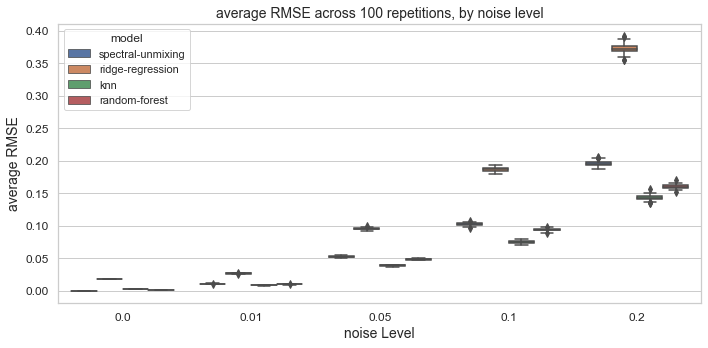

In [30]:
# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='model', data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

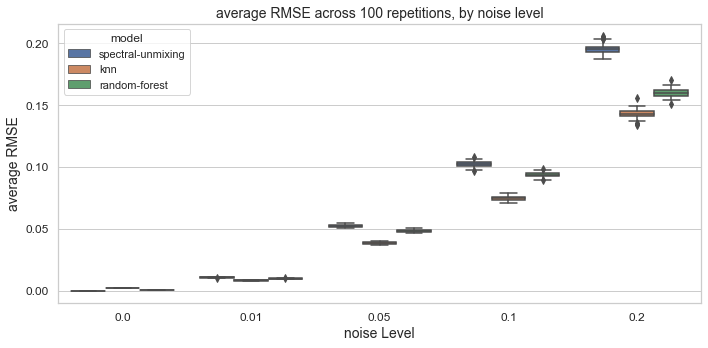

In [31]:
# Box Plot of result -- without ridge-regression
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', 
            y='avg_rmse', 
            hue='model', 
            data = results.loc[results['model']!='ridge-regression'])
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()